# Mount Drive



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Importing Libraries and initializing stopwords and stemmer


In [ ]:
!pip3 install texthero
!pip3 install transformers
!pip3 install tensorflow_addons


In [ ]:
!pip install tweet-preprocessor

import seaborn as sns 
import matplotlib.pyplot as plt 
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

In [ ]:
import re 
import nltk
from wordcloud import WordCloud
from nltk.stem import WordNetLemmatizer 
from textblob import TextBlob,Word
from nltk.corpus import words
nltk.download('words')
nltk.download('wordnet')
import texthero as hero       # to be learned
import re
from texthero import stopwords

from nltk.corpus import wordnet #to be learned

import tensorflow as tf

from nltk.corpus import stopwords
from nltk.tokenize import TweetTokenizer

import tensorflow as tf

from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score,f1_score, confusion_matrix

[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Unzipping corpora/words.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
def lemma_per_pos(sent):
    '''function to lemmatize according to part of speech tag'''
    tweet_tokenizer=TweetTokenizer()
    lemmatizer = nltk.stem.WordNetLemmatizer()
    lemmatized_list = [lemmatizer.lemmatize(w) for w in  tweet_tokenizer.tokenize(sent)]
    return " ".join(lemmatized_list)

def df_preprocessing(df,feature_col):
    '''
    Preprocessing of dataframe
    '''
    stop = set(stopwords.words('english'))
    df[feature_col]= (df[feature_col].pipe(hero.lowercase).
                      pipe(hero.remove_urls).
                      pipe(hero.remove_digits).
                      pipe(hero.remove_punctuation).
                      pipe(hero.remove_html_tags) )
    # lemmatization
    df[feature_col]= [lemma_per_pos(sent) for sent in df[feature_col]]
    #df[col_name]= hero.remove_stopwords(df[col_name],custom_stopwords)
    return df

In [ ]:
from transformers import AutoTokenizer,TFDistilBertModel, DistilBertConfig
from transformers import TFAutoModel
import tensorflow as tf 
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout
from transformers import AdamW, get_linear_schedule_with_warmup
import tensorflow_addons as tfa

# Reading Data


In [ ]:
hasoc_train = pd.read_csv("/content/drive/MyDrive/ML JCOMP SEM5/modified_hasoc_task21.csv") #Your respective address 
hasoc_train.head()
## change data

,_id,text,hate,offen,prof,none
0,60c5d6bf5659ea5e55defa2c,@wealth if you made it through this &amp;&amp;...,0,0,1,0
1,60c5d6bf5659ea5e55def461,Technically that's still turning back the cloc...,0,1,0,0
2,60c5d6bf5659ea5e55defaad,@VMBJP @BJP4Bengal @BJP4India @narendramodi @J...,0,0,0,1
3,60c5d6bf5659ea5e55def419,@krtoprak_yigit Soldier of Japan Who has dick ...,0,1,0,0
4,60c5d6bf5659ea5e55def7fa,@blueheartedly You'd be better off asking who ...,0,1,0,0


In [ ]:
hasoc_train.drop("_id",inplace=True,axis=1)

In [ ]:
hasoc_test = pd.read_csv("/content/drive/MyDrive/ML JCOMP SEM5/en_Hasoc2021_test_data.csv")
hasoc_test.head()

,_id,text
0,60c5d6bf5659ea5e55deffcb,Fewer people coming in for vaccinations. So sa...
1,60c5d6bf5659ea5e55df028c,@MattHancock This may all be true. But... What...
2,60c5d6bf5659ea5e55def377,@Layla_EFC I’ve unfollowed him the wanker
3,60c5d6bf5659ea5e55def4c7,You guys are losing it all over the world. The...
4,60c5d6bf5659ea5e55df01a6,"And thus death laughs... It is sad merriment, ..."


In [ ]:
hasoc_test.drop("_id",inplace=True,axis=1)

In [ ]:
combined_data=pd.read_csv("/content/drive/MyDrive/ML JCOMP SEM5/hate_bin_combine.csv",encoding="ISO-8859-1")

In [ ]:
combined_data.head()

,_id,text,task_1
0,60c5d6bf5659ea5e55defa2c,@wealth if you made it through this &amp;&amp;...,HOF
1,60c5d6bf5659ea5e55def461,Technically that's still turning back the cloc...,HOF
2,60c5d6bf5659ea5e55defaad,@VMBJP @BJP4Bengal @BJP4India @narendramodi @J...,NOT
3,60c5d6bf5659ea5e55def419,@krtoprak_yigit Soldier of Japan Who has dick ...,HOF
4,60c5d6bf5659ea5e55def7fa,@blueheartedly You'd be better off asking who ...,HOF


In [ ]:
combined_data.drop("_id",inplace=True,axis=1)

In [ ]:
test_bin_labels=pd.read_csv("/content/drive/MyDrive/ML JCOMP SEM5/1A_English_actual_labels.csv")
test_mul_labels=pd.read_csv("/content/drive/MyDrive/ML JCOMP SEM5/1B_English_actual_labels.csv")

### run when performing multiclass

In [ ]:
hasoc_test["task_2"]=test_mul_labels["label"]

### run when performing binary class

In [ ]:
hasoc_test["task_1"]=test_bin_labels["label"]

## ONE HOT ENCODING CLASS LABELS

In [ ]:
def one_hot(data):
  column_names = ["text","hate","offen","prof","none"]
  test_df = pd.DataFrame(columns = column_names)

  for i in range(len(data)):
    text_temp = data['text'].iloc[i]
    if data['task_2'].iloc[i] == "NONE":
      test_df.loc[i] = [text_temp,0,0,0,1]
    elif data['task_2'].iloc[i] == "PRFN":
      test_df.loc[i] = [text_temp,0,0,1,0]
    elif data['task_2'].iloc[i] == "OFFN":
      test_df.loc[i] = [text_temp,0,1,0,0]
    elif data['task_2'].iloc[i] == "HATE":
      test_df.loc[i] = [text_temp,1,0,0,0]
  return test_df


In [ ]:
hasoc_test=one_hot(hasoc_test)

In [ ]:
hasoc_train

,text,hate,offen,prof,none
0,@wealth if you made it through this &amp;&amp;...,0,0,1,0
1,Technically that's still turning back the cloc...,0,1,0,0
2,@VMBJP @BJP4Bengal @BJP4India @narendramodi @J...,0,0,0,1
3,@krtoprak_yigit Soldier of Japan Who has dick ...,0,1,0,0
4,@blueheartedly You'd be better off asking who ...,0,1,0,0
...,...,...,...,...,...
3838,@BBCNews Let the dog deal with the wanker once...,0,0,1,0
3839,India has suffered a lot. That Chinese bastard...,1,0,0,0
3840,People didn't give 300+ seats majority to BJP ...,1,0,0,0
3841,"@KanganaTeam This is such a vile, xenophobic a...",0,0,1,0


In [ ]:
target_col= hasoc_train.columns[1:]
feature_col=hasoc_train.columns[0:1]

#Preprocessing

In [ ]:
target_col,feature_col

(Index(['hate', 'offen', 'prof', 'none'], dtype='object'),
 Index(['text'], dtype='object'))

### preprocessing training and testing data

In [ ]:
with tf.device('/GPU:0'): 
 hasoc_tr_prp= df_preprocessing(hasoc_train,feature_col[0])

In [ ]:
 hasoc_tt_prp = df_preprocessing(hasoc_test,feature_col[0])

In [ ]:
#Creating tokenizer
def create_tokenizer(pretrained_weights='distilbert-base-uncased'):
  '''Function to create the tokenizer'''

  tokenizer = AutoTokenizer.from_pretrained(pretrained_weights)
  return tokenizer

#Tokenization of the data
def data_tokenization(dataset,feature_col,max_len,tokenizer):
    '''dataset: Pandas dataframe with feature name is column name 
    Pretrained_weights: selected model 
    RETURN: [input_ids, attention_mask]'''

    tokens = dataset[feature_col].apply(lambda x: tokenizer(x,return_tensors='tf', 
                                                            truncation=True,
                                                            padding='max_length',
                                                            max_length=max_len, 
                                                            add_special_tokens=True))
    input_ids= []
    attention_mask=[]
    for item in tokens:
        input_ids.append(item['input_ids'])
        attention_mask.append(item['attention_mask'])
    input_ids, attention_mask=np.squeeze(input_ids), np.squeeze(attention_mask)


    return [input_ids,attention_mask]

#Model 

In [ ]:
def bert_model(pretrained_weights,max_len,learning_rate):
  '''BERT model creation with pretrained weights
  INPUT:
  pretrained_weights: Language model pretrained weights
  max_len: input length '''
  print('Model selected:', pretrained_weights)
  bert=TFAutoModel.from_pretrained(pretrained_weights)
  
  # This is must if you would like to train the layers of language models too.
  for layer in bert.layers:
      layer.trainable = True

  # # parameter declaration
  # step = tf.Variable(0, trainable=False)
  # schedule = tf.optimizers.schedules.PiecewiseConstantDecay([10000, 15000], [2e-0, 2e-1, 1e-2])
  # # lr and wd can be a function or a tensor
  # lr = learning_rate * schedule(step)
  # wd = lambda:lr * schedule(step)
  # optimizer = tfa.optimizers.AdamW(learning_rate=lr, weight_decay=wd)

  # optimizer= tf.keras.optimizers.Adam(learning_rate=learning_rate, beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=False,name='Adam')
  optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate)

  # declaring inputs, BERT take input_ids and attention_mask as input
  input_ids= Input(shape=(max_len,),dtype=tf.int32,name='input_ids')
  attention_mask=Input(shape=(max_len,),dtype=tf.int32,name='attention_mask')

  bert= bert(input_ids,attention_mask=attention_mask)
  x= bert[0][:,0,:]
  x=tf.keras.layers.Dropout(0.05)(x)
  # x= tf.keras.layers.Dense(128)(x)
  x=tf.keras.layers.Dense(64)(x)
  x=tf.keras.layers.Dense(32)(x)

  output=tf.keras.layers.Dense(4,activation='sigmoid')(x)

  model=Model(inputs=[input_ids,attention_mask],outputs=[output])
  # compiling model 
  model.compile(optimizer=optimizer,
                loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE,name='categorical_crossentropy'),
                metrics=['accuracy'])
  return model

In [ ]:
pretrained_weights='bert-base-uncased'
max_len=256
epochs=6
learning_rate=2e-5
batch_size=4

In [ ]:
tokenizer= create_tokenizer()

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

In [ ]:
x_train= data_tokenization(hasoc_tr_prp,feature_col[0],max_len,tokenizer) 

In [ ]:
y_train= hasoc_tr_prp[target_col].values
y_train

array([[0, 0, 1, 0],
       [0, 1, 0, 0],
       [0, 0, 0, 1],
       ...,
       [1, 0, 0, 0],
       [0, 0, 1, 0],
       [0, 0, 0, 1]])

In [ ]:
y_train.shape

(3843, 4)

In [ ]:
bert=bert_model(pretrained_weights,max_len,learning_rate)
bert.summary()

Model selected: bert-base-uncased


Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 256)]        0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, 256)]        0           []                               
                                                                                                  
 tf_bert_model_1 (TFBertModel)  TFBaseModelOutputWi  109482240   ['input_ids[0][0]',              
                                thPoolingAndCrossAt               'attention_mask[0][0]']         
                                tentions(last_hidde                                               
                                n_state=(None, 256,                                         

In [ ]:
x_train=x_train.astype(np.float32)
y_train=x_train.asarray(y_train).astype(np.float32)

In [ ]:
with tf.device('/GPU:0'):
    bert.fit(x_train,y_train,batch_size=batch_size,epochs=epochs,verbose=1)

Epoch 1/6


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1096: UserWarning:

"`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"



961/961 [==============================] - 489s 487ms/step - loss: 0.4134 - accuracy: 0.6071
Epoch 2/6
961/961 [==============================] - 468s 487ms/step - loss: 0.2987 - accuracy: 0.7335
Epoch 3/6
961/961 [==============================] - 467s 486ms/step - loss: 0.1844 - accuracy: 0.8525
Epoch 4/6
961/961 [==============================] - 468s 487ms/step - loss: 0.0874 - accuracy: 0.9394
Epoch 5/6
961/961 [==============================] - 466s 485ms/step - loss: 0.0531 - accuracy: 0.9649
Epoch 6/6
961/961 [==============================] - 465s 483ms/step - loss: 0.0421 - accuracy: 0.9727


In [ ]:
!mkdir -p saved_model
bert.save('saved_model/my_model') 

INFO:tensorflow:Assets written to: saved_model/my_model/assets


INFO:tensorflow:Assets written to: saved_model/my_model/assets
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning:

Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.



## tokenizing test data

In [ ]:
x_test= data_tokenization(hasoc_tt_prp,feature_col[0],max_len,tokenizer)
x_test

[array([[  101,  8491,  2111, ...,     0,     0,     0],
        [  101,  4717,  4819, ...,     0,     0,     0],
        [  101, 19786,  1041, ...,     0,     0,     0],
        ...,
        [  101, 22079,  2050, ...,     0,     0,     0],
        [  101,  2282, 21759, ...,     0,     0,     0],
        [  101, 15467, 19722, ...,     0,     0,     0]], dtype=int32),
 array([[1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        ...,
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0]], dtype=int32)]

In [ ]:
preds= bert.predict(x_test)

In [ ]:
preds.shape
predicted_test_labels=pd.DataFrame(preds)

In [ ]:
predicted_test_labels

,hate,offen,prof,none
0,0.000048,0.000018,9.849921e-07,0.999965
1,0.000048,0.000047,9.993369e-01,0.000393
2,0.000022,0.000442,9.995970e-01,0.000079
3,0.287869,0.008124,8.851427e-05,0.740902
4,0.000012,0.000028,5.743566e-05,0.999894
...,...,...,...,...
1276,0.940327,0.034539,6.961226e-05,0.029514
1277,0.000141,0.000007,9.999634e-01,0.000017
1278,0.000606,0.000059,8.090886e-01,0.340588
1279,0.011510,0.000378,6.929170e-01,0.438285


In [ ]:
predicted_test_labels.columns=["hate","offen","prof","none"]

In [ ]:
pred_labels=[]
for i in range(predicted_test_labels.shape[0]):
  temp = max(predicted_test_labels['hate'].iloc[i],predicted_test_labels['offen'].iloc[i],predicted_test_labels['none'].iloc[i],predicted_test_labels['prof'].iloc[i])
  if temp == predicted_test_labels['hate'].iloc[i]:
    pred_labels.append('HATE')
  elif temp == predicted_test_labels['offen'].iloc[i]:
    pred_labels.append('OFFN')
  elif temp == predicted_test_labels['prof'].iloc[i]:
    pred_labels.append('PRFN')
  elif temp == predicted_test_labels['none'].iloc[i]:
    pred_labels.append('NONE')

In [ ]:
true_labels=test_mul_labels.label

In [ ]:
from sklearn.metrics import classification_report

In [ ]:
true_labels=list(true_labels)

## performance on hasoc test data 

In [ ]:
print(classification_report(true_labels,pred_labels))

              precision    recall  f1-score   support

        HATE       0.52      0.48      0.50       224
        NONE       0.75      0.68      0.71       483
        OFFN       0.47      0.42      0.44       195
        PRFN       0.71      0.86      0.78       379

    accuracy                           0.66      1281
   macro avg       0.61      0.61      0.61      1281
weighted avg       0.65      0.66      0.65      1281



In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

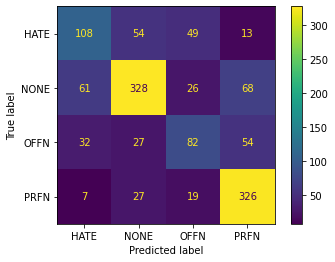

In [ ]:
cm = confusion_matrix(true_labels, pred_labels, labels=["HATE","NONE","OFFN","PRFN"])
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=["HATE","NONE","OFFN","PRFN"])
disp.plot()
plt.show()